### Plotting Test
Alex is using this Jupyter notebook to test the plotting + print statements from query.py.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lsst.rsp import get_tap_service
import query as q

##### Testing object classifcation
There are two ways this classification function works:
1. Providing orbit parameters, returning a corresponding object type
2. Providing an object type, reutrning corresponding orbit parameters

In [2]:
# 1
input_params = {
        "q_cutoff_min": None, 
        "q_cutoff": None,
        "a_cutoff_min": None, 
        "a_cutoff": None,
        "e_cutoff_min": None, 
        "e_cutoff": None,
        "t_cutoff_min": 2.0,
        "t_cutoff": 3.0}

object_type = q.type_classification(input_params = input_params)
print(object_type)

#2
params = q.type_classification(object_type = "JFC")
print(params)

JFC
{'t_cutoff_min': 2.0, 't_cutoff': 3.0}


Now that know our classification works, let's try making a full query. 

In [3]:
# testing with NEOs
query, object_type = q.make_query_general(object_type = "NEO", join = 'Diasource')
print(query)
print(object_type)

query, object_type = q.make_query_general(q_cutoff=1.3, a_cutoff=4.0, e_cutoff = 1.0, join = 'Diasource')
print(query)
print(object_type) 


SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, dias.magTrueVband, dias.band FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
NEO
SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, dias.magTrueVband, dias.band FROM dp03_catalogs_10yr.MPCORB as mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
NEO


In [4]:
# running the query
NEO_objects_table = q.run_query(query)

Job phase is COMPLETED
     incl              q                  e          ... magTrueVband band
     deg               AU                            ...                  
-------------- ------------------ ------------------ ... ------------ ----
9.299357471305 1.0442646753695681 0.5038040861600521 ...     22.00147    z
9.299357471305 1.0442646753695681 0.5038040861600521 ...    22.000353    i
9.299357471305 1.0442646753695681 0.5038040861600521 ...    21.968763    r
9.299357471305 1.0442646753695681 0.5038040861600521 ...    22.549915    z
9.299357471305 1.0442646753695681 0.5038040861600521 ...    21.820671    r


In [5]:
# Adding calculated + object_type columns to data table
a = q.calc_semimajor_axis(NEO_objects_table['q'], NEO_objects_table['e'])
NEO_objects_table['a'] = a
NEO_objects_table['object_type'] = object_type

print(NEO_objects_table[0:5]) # print first few rows 
print(NEO_objects_table.columns)

     incl              q          ...         a          object_type
     deg               AU         ...                               
-------------- ------------------ ... ------------------ -----------
9.299357471305 1.0442646753695681 ... 2.1045410617919846         NEO
9.299357471305 1.0442646753695681 ... 2.1045410617919846         NEO
9.299357471305 1.0442646753695681 ... 2.1045410617919846         NEO
9.299357471305 1.0442646753695681 ... 2.1045410617919846         NEO
9.299357471305 1.0442646753695681 ... 2.1045410617919846         NEO
<TableColumns names=('incl','q','e','ssObjectID','magTrueVband','band','a','object_type')>


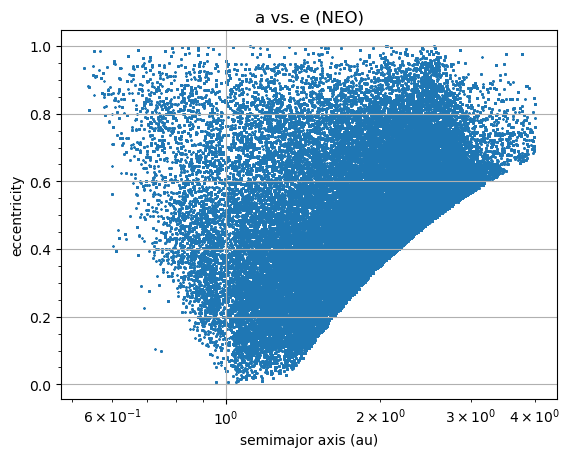

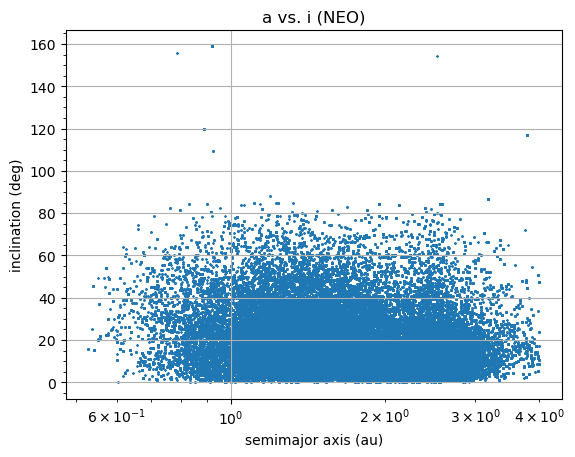

In [6]:
q.plot_data(NEO_objects_table)

# # Manual Plotting Code 
fig, ax = plt.subplots()
# plt.xlim([0., 4.])
# plt.ylim([0., 1.])
ax.scatter(NEO_objects_table["a"], NEO_objects_table["e"], s=0.1) # a vs. i
ax.set_xscale('log')
ax.set_xlabel('semimajor axis (au)')
ax.set_ylabel('eccentricity')
ax.set_title("a vs. e (NEO)")
ax.minorticks_on()
ax.grid()
plt.show()

In [7]:
# q.type_counts(NEO_objects_table)
print(NEO_objects_table.columns)
df = NEO_objects_table.to_pandas()
print(df['object_type'].value_counts())
type(df['object_type'].value_counts())

<TableColumns names=('incl','q','e','ssObjectID','magTrueVband','band','a','object_type')>
object_type
NEO    2135926
Name: count, dtype: int64


pandas.core.series.Series

#### How many observations for each object? In what filters?

In [8]:
# need to count observations for each unique object in SSO_id
print(df['ssObjectID'].value_counts())

ssObjectID
-6531816816762911299    1708
-7495537061370576217    1316
-8960445666237157474    1084
 5885925787919145121     993
-3541095373223286452     991
                        ... 
 8210757616290374451       6
-5675138216577684964       6
-317670342693814751        6
-7554881316084645816       6
 4738261344712572538       6
Name: count, Length: 39470, dtype: int64


In [9]:
# unique observations within each filter
print(df['band'].value_counts())

band
r    754794
i    686043
z    419419
g    275670
Name: count, dtype: int64


In [10]:
# count of unique observations for each unique object in SSO_id within each filter
print(df.groupby(['ssObjectID', 'band']).size().reset_index(name='obs_filter_count'))


                 ssObjectID band  obs_filter_count
0      -9222952578217572358    g                 4
1      -9222952578217572358    i                11
2      -9222952578217572358    r                12
3      -9222952578217572358    z                 6
4      -9222820784385736130    g                 7
...                     ...  ...               ...
153755  9222765823057774610    z                 4
153756  9222996671474961129    g                 1
153757  9222996671474961129    i                 5
153758  9222996671474961129    r                 7
153759  9222996671474961129    z                 4

[153760 rows x 3 columns]


#### What is the average magnitude range? Does any object have an unusually large range?

Want to group everything by its object type, then group the observations by object, then want to get the min/max brightnesses from each object, then want to get average min/max values, then if something is more than one std.dev away, want to call it out. 

In [16]:
df.columns

Index(['incl', 'q', 'e', 'ssObjectID', 'magTrueVband', 'band', 'a',
       'object_type'],
      dtype='object')

In [22]:
# 1. Group observations by object type, by ssObjectID
grouped_obs_data = df.groupby(['object_type', 'ssObjectID']).agg(
    mag_min = ('magTrueVband', 'min'), 
    mag_max = ('magTrueVband', 'max'), 
    mag_mean = ('magTrueVband', 'mean')
)

print(grouped_obs_data)

                                    mag_min    mag_max   mag_mean
object_type ssObjectID                                           
NEO         -9222952578217572358  20.865181  28.316063  22.341082
            -9222820784385736130  21.404852  29.954420  25.140797
            -9222809672762914664  29.152020  31.880566  30.732315
            -9222638543944259679  20.660261  20.916206  20.807749
            -9222469573562197566  21.441607  25.298536  22.376635
...                                     ...        ...        ...
             9221626825731835023  21.376930  26.843601  23.258450
             9222267589414335277  18.893867  23.640882  21.959656
             9222476822316093977  18.088520  24.029242  22.102621
             9222765823057774610  27.979145  29.599825  28.464285
             9222996671474961129  22.383114  23.973074  22.934273

[39470 rows x 3 columns]


In [29]:
# want to look at when the range has a larger spread than normal, so want to get the std. deviation of the range
mag_range = grouped_obs_data["mag_max"] - grouped_obs_data["mag_min"]
print(mag_range)
grouped_obs_data['mag_range'] = mag_range

print("Standard Deviation of Range:", np.std(mag_range))
print("Mean Range:", np.mean(mag_range))

object_type  ssObjectID          
NEO          -9222952578217572358    7.450882
             -9222820784385736130    8.549568
             -9222809672762914664    2.728546
             -9222638543944259679    0.255945
             -9222469573562197566    3.856930
                                       ...   
              9221626825731835023    5.466671
              9222267589414335277    4.747015
              9222476822316093977    5.940722
              9222765823057774610    1.620680
              9222996671474961129    1.589960
Length: 39470, dtype: float32
Index(['mag_min', 'mag_max', 'mag_mean', 'mag_range'], dtype='object')
Standard Deviation of Range: 2.377028226852417
Mean Range: 4.574746


In [31]:
# Now we have the the mean and std. dev, so to look for unusually large ranges, need to see the ranges that have more range than mean + std dev
large_criterion = np.mean(mag_range) + np.std(mag_range)
print(f"Large range criterion:", large_criterion)
filtered_large_ranges = grouped_obs_data[grouped_obs_data['mag_range'] > large_criterion]
print(filtered_large_ranges)

Large range criterion: 6.9517746
                                    mag_min    mag_max   mag_mean  mag_range
object_type ssObjectID                                                      
NEO         -9222952578217572358  20.865181  28.316063  22.341082   7.450882
            -9222820784385736130  21.404852  29.954420  25.140797   8.549568
            -9221863656130805355  22.426601  31.148899  24.587442   8.722298
            -9219171728267255250  19.298977  28.877172  22.183498   9.578196
            -9218723282399313038  19.319479  26.867752  21.364487   7.548273
...                                     ...        ...        ...        ...
             9201935909984713157  18.843180  28.005829  22.224932   9.162649
             9208298150249762471  17.683380  27.085598  20.792793   9.402218
             9211783422354525147  22.841520  30.240187  26.505634   7.398666
             9214642111520763103  22.792412  30.669680  24.940960   7.877268
             9217891249564187237  18.627748

In [14]:
# need to group by unique ssObjectID values
# create new dataframe to hold average of each group 

print(df.columns)

mag_data = df.groupby(['ssObjectID']).agg(
    mag_mean = ('magTrueVband', 'mean'))

print(mag_data)

Index(['incl', 'q', 'e', 'ssObjectID', 'magTrueVband', 'band', 'a',
       'object_type'],
      dtype='object')
                       mag_mean
ssObjectID                     
-9222952578217572358  22.341082
-9222820784385736130  25.140797
-9222809672762914664  30.732315
-9222638543944259679  20.807749
-9222469573562197566  22.376635
...                         ...
 9221626825731835023  23.258450
 9222267589414335277  21.959656
 9222476822316093977  22.102621
 9222765823057774610  28.464285
 9222996671474961129  22.934273

[39470 rows x 1 columns]


#### Now need to look at the average range
For each object, need to find the average range? So, min and max for each observation?
-> I think this means the average range by object type, so I'm going to group by object type, then find min and max V values from each object type

In [15]:
df.groupby('Class')['magTrueVband'].min()

KeyError: 'Class'

In [ ]:
df.groupby('Class')['magTrueVband'].max()

In [ ]:
q.type_counts(DiaSource_joined_table)